In [1]:
import gym
#import moviepy.editor as mpy
import os
from pyvirtualdisplay import Display

In [2]:
# Filter tensorflow version warnings
import os
# https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import warnings
# https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
import logging
tf.get_logger().setLevel(logging.ERROR)

In [3]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np

from stable_baselines import PPO2

In [4]:
#cargo el env original de OpenAI
env = gym.make('CarRacing-v0')

In [5]:
env.action_space

Box(3,)

In [6]:
env.action_space.high, env.action_space.low

(array([1., 1., 1.], dtype=float32), array([-1.,  0.,  0.], dtype=float32))

In [7]:
env.observation_space

Box(96, 96, 3)

In [8]:
#modelos propios multi-frame, segun el env_v1 de Mike que lo permite

#param comunes de imagenes usados en train
G=1   #rgb o grayscale o green
discre=True
intro=45
acc_prev=0

#model = PPO2.load('gym-master/ppo2_v1_mike_cnn_gray.pkl')       #cuidado 2 frames
C=2

model = PPO2.load('gym-master/ppo2_v1_mike_cnn_4f_green_bs1600.pkl')
C=4
G=2

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [9]:
#mike's training discretization
act=[]
act.append([0, 0, 0])
act.append([-1,0, 0])
act.append([1, 0, 0])
act.append([0,1,0])
act.append([0, 0,0.8])

In [10]:
#setup
plot=False   #si plot no render grande

if plot:
    display = Display(visible=0, size=(1024, 768))
    display.start()
    os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

rgb=env.reset()

#salteo la intro si uso 45 frames, lo pongo a acelerar segun env entretanto
for i in range(intro):
    rgb, reward, done, info = env.step([0, acc_prev, 0])
    

Track generation: 1140..1429 -> 289-tiles track


In [11]:
#armo array de obser inicial 
#--> hay sendos wrapper para esto, pero no puedo agregarle a TU entorno la
# opcion de quedarme solo con el canal green de rgb (G=2)

obser=np.zeros((96,96,C))

for i in range(C):
    if G==1: 
        obs=np.average(rgb, weights=[0.299, 0.587, 0.114], axis=2)
    elif G==2:
        obs=rgb[:,:,1]
    else:
        obs=rgb[:,:,i]
    
    obser[:,:,i]=obs
#    rgb, reward, done, info = env.step([0, acc_prev, 0])  #acelero segun env estos C frames...

env.render()

True

In [12]:
obser.shape

(96, 96, 4)

In [13]:
#play
episode = intro
total_reward = 0  
rewards = []
total_rewards = []
done = False
np.set_printoptions(precision=4)

#si plot no render grande

while not done and episode<1003:  #a los mil corta el env() automaticamente
    mod_act, _states = model.predict(obser, deterministic=True)
    action=act[mod_act] if discre else mod_act
    
    rgb, reward, done, info = env.step(action)
    #obs=np.average(rgb, weights=[0.299, 0.587, 0.114], axis=2) if G else rgb
    if G==1: 
        obs=np.average(rgb, weights=[0.299, 0.587, 0.114], axis=2)
    elif G==2:
        obs=rgb[:,:,1]
    else:
        obs=rgb
    
    if C>1:
        obser=np.roll(obser,1,2)
        obser[:,:,0]=obs
    else:
        obser=obs
    
    total_reward += reward
    rewards.append(reward)
    total_rewards.append(total_reward)
    
    if plot:
        clear_output(wait=True)
        plt.subplots(1,2,figsize=(15,10))
        plt.subplot(1,2, 1)
        plt.imshow(obs,cmap='gray')   #imagen mas nueva que ve la red para decidir, guarda C anteriores
        plt.subplot(1,2,2)
        plt.imshow(rgb)               #el juego en estado natural
        plt.show()
        #print(f'\r{model.action_probability(obser):.4f}')
        print(model.action_probability(obser))
    else:
        env.render()
        
    episode+=1
    #print(mod_act, act[mod_act])
    print(f'\r{reward:.2f}, {action}, {total_reward:.2f}, {episode}', end='                           ')

print('')
print('')
print('env() lo dio por finalizado: ', done)
print(f'\r{info}, {total_reward:.2f}, {episode}')

env.close()

-0.10, [0, 1, 0], 869.78, 1000                                                      

env() lo dio por finalizado:  True
{'TimeLimit.truncated': True}, 869.78, 1000


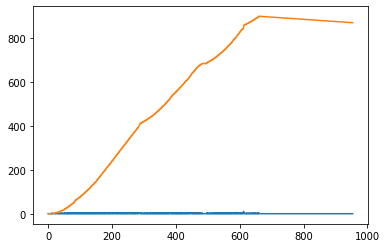

In [14]:
plt.plot(rewards[:episode-1])
plt.plot(total_rewards[:episode])

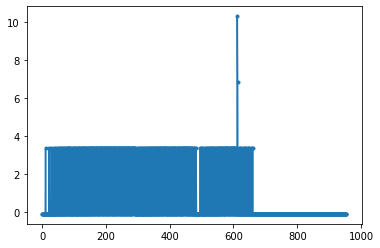

In [15]:
plt.plot(rewards, marker='.')

In [16]:
env.close()